<a href="https://colab.research.google.com/github/felluksch/length_of_a_polygon/blob/main/polygonlength.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we're trying to estimate the "length of a polygon". This is not a well defined metric; one might describe length in terms of the bounding box of a polygon or approximate a curve that follows the primary axis of the polygon. Depending on the shape of the polygon, humans might intuitively give preference to either of the definitions; e.g. if the polygon approximates a curve, we would describe the "length" in terms of that curve. If the shape is more complex, however, most people would probably simplify the geometry mentally and simply draw a straight line along the principal axis of the polygon.

Here, we try two methods more akin to the "curve fitting" approach:

1. For a polygon where the x-extent is greater than the y-extent, we calculate the midpoints between y-coords for all x-coords and create a LineString connecting these midpoints.
2. We compute the skeleton of the polygon and take the longest path in the skeleton graph as the length of the polygon.

But first we need to load the required packages.

In [25]:
!pip install geopandas
!pip install alphashape
!pip install skan
#!pip install https://github.com/scikit-image/scikit-image/archive/refs/tags/v0.18.3.tar.gz

In [26]:
import numpy as np
from shapely.geometry import Polygon, MultiPoint, LineString, MultiLineString, Point
import alphashape
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from skimage.morphology import medial_axis, skeletonize
import scipy.sparse as sparse
import skan
import gdal
import ogr

We write two classes that we use to generate synthetic data: `GenericPolygon` is a parent class that takes a polygon geometry. In the following, we work with the child class `RandomPolygon` that inherits from `MyPolygon` and generates a polygon (concave or convex) consisting of random coordinates.

In [27]:
class GenericPolygon:
  """
  Class that represents a generic polygon.
  Args:
    - geometry: Polygon geometry (GeoSeries)
  """
  def __init__(self, geometry):
    self.geometry = geometry
    self.bbox = self.geometry.bounds
    self.flip_if_necessary()
  
  def flip_if_necessary(self): # swap x/y so that x-extent is greater than y-extent
    if self.bbox.maxx[0] - self.bbox.minx[0] < self.bbox.maxy[0] - self.bbox.miny[0]:
      print("swapped coordinates")
      flipped_coords = [(c[1],c[0]) for c in (self.geometry[0].exterior.coords)]
      self.geometry = gpd.GeoSeries(Polygon(flipped_coords))
      self.bbox = self.geometry.bounds

class RandomPolygon(GenericPolygon):
  def __init__(self, extent, crs, polytype):
    """
    Class that represents a randomly generated polygon.
    Args:
      - extent: range for randomly generated coordinates as 4-uple of floats: (xmin, xmax, ymin, ymax), format must be aligned with crs
      - crs: coordinate reference systems as string, e.g. "epsg:4326" for WGS84
      - polytype: two options "concave" or "convex"
    """
    self.polytype = polytype # concave or convex
    geom = self.create_geom(extent, crs)
    GenericPolygon.__init__(self, geom)

  def generate_coords(self, extent):
    lon = np.random.uniform(low=extent[0], high=extent[1], size=10) 
    lat = np.random.uniform(low=extent[2], high=extent[3], size=10)
    return list(zip(lon,lat))

  def create_geom(self, extent, crs):
    self.coords = self.generate_coords(extent)
    if self.polytype == "convex":
      poly = Polygon(self.coords) # to polygon
      geom = gpd.GeoSeries(poly.convex_hull) # take convex hull
    elif self.polytype == "concave":
      geom = gpd.GeoSeries(alphashape.alphashape(self.coords))
    geom.set_crs(crs)
    return geom

swapped coordinates


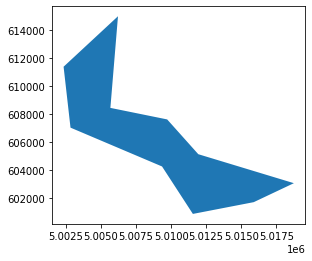

In [28]:
random_poly = RandomPolygon((600000.0, 620000.0, 5000000.0, 5020000.0), "epsg:32630", "concave")
random_poly.geometry.plot()

We first try a very simple approach: for a polygon where the x-extent is greater than the y-extent, we calculate the midpoints between y-coords for all x-coords. We take the length of a LineString connecting all these midpoints as the "length of the polygon".

In [29]:
class LengthEstimatorSimple:
  def __init__(self, poly, res):
    """
    Initialise an estimator for the length of a polygon by calculating the length of a path consisting of the 
    midpoints between y-coords for all x-coords.
    Run method "estimate" to obtain results.
    Args:
      - poly: Polygon geometry (GeoSeries)
      - res: x-coord interval (calculate points for x coordinates that are "res" apart)
    """
    self.poly = poly
    self.xs = range(int(np.ceil(poly.bbox.minx[0])), int(np.floor(poly.bbox.maxx[0])), res) # generate array of x coords

  def get_midpoint(self, x):
    isect = self.poly.geometry.exterior.intersection(LineString([(x, self.poly.bbox.miny[0]), (x, self.poly.bbox.maxy[0])]))[0] # ignore multiple intersections, take the outermost ones
    return LineString([isect[0], isect[-1]]).interpolate(0.5, normalized = True)

  def get_path(self):
    return [self.get_midpoint(x) for x in self.xs]

  def estimate(self):
    path = self.get_path()
    length = 0
    for a, b in zip(path, path[1:]):
      length += a.distance(b)
    return round(length, 5)

length: 21902.57317


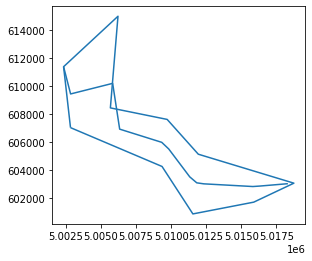

In [30]:
estim = LengthEstimatorSimple(random_poly, 500) # only works well if there is a max of 2 y-coords for every x-coord
length = estim.estimate()
print("length:", length)

path = LineString(estim.get_path())
gpd.GeoSeries(random_poly.geometry.exterior.union(path)).plot()

This works alright for simple convex geometries but fails for more complex geometries. Overall, not a good solution.

We try a different approach making use of the [skeleton of the polygon](https://en.wikipedia.org/wiki/Topological_skeleton).

We save the random poly to a file and rasterise in the next step.

In [31]:
random_poly.geometry.to_file(driver='ESRI Shapefile', filename="polygon1.shp")

In [32]:
def rasterise(shp_path, output_path):
  """
  Save raster representation of ESRI Shapefile vector layer to GeoTIFF. 
  Args:
    - shp_path: Path to input layer (ESRI Shapefile) as string
    - output_path: Path to output layer as string
  """
  shp = ogr.Open(shp_path)

  shp_layer = shp.GetLayer(0)
  xmin, xmax, ymin, ymax = shp_layer.GetExtent()
  pixel_size = 100

  ds = gdal.Rasterize(output_path, shp_path, xRes=pixel_size, yRes=pixel_size, 
                    burnValues=1, outputBounds=[xmin, ymin, xmax, ymax], 
                    outputType=gdal.GDT_Byte)
  ds = None
  return output_path

rasterise("polygon1.shp", "raster1.geotiff")

'raster1.geotiff'

Now we open the newly created raster file.

(5002332.850079245, 100.0, 0.0, 614993.6675349879, 0.0, -100.0)
[0 1]


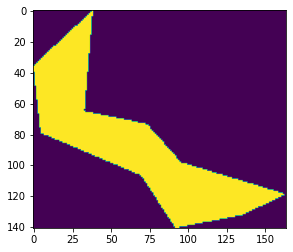

In [33]:
raster = gdal.Open("raster1.geotiff")
gt = raster.GetGeoTransform()
print(gt)

raster_arr = raster.ReadAsArray()
print(np.unique(raster_arr))
plt.imshow(raster_arr)

We write a class that estimates the length based on the skeleton of the polygon.

In [34]:
class LengthEstimatorSkeleton:
  def __init__(self, raster_arr, gt):
    """
    Initialise an estimator for the length of a polygon by calculating the longest path between endpoints of its skeleton.
    Run method "estimate" to obtain results.
    Args:
      - raster_arr: 2-dimensional numpy array representation of a raster layer, where 0 = null and 1 = polygon shape
      - gt: GDAL GeoTransform object of the raster layer
    """
    self.raster = raster_arr
    self.gt = gt
    self.skel = skeletonize(raster_arr)

  def plot_skeleton(self):
    nonzeros = np.nonzero(self.skel.astype(int))
    for x,y in zip(nonzeros[0], nonzeros[1]):
      self.raster[x,y] = 0.5

    plt.imshow(self.raster)

  def estimate(self):
    """
    This method uses the skan package to generate a DataFrame where each row corresponds to an edge in a graph representation of the skeleton
    (nodes = junctions and endpoints, edges = path between them). We rename the nodes and create a sparse distance matrix that stores the weights of 
    the edges (negative distance between nodes). We run a shortest path algorithm on the matrix, the size of the smallest value denotes the longest path,
    since shortest path with negative weights = longest path.
    """
    branches = skan.summarize(skan.Skeleton(self.skel)) # generate df of all edges in skeleton

    all_nodes = sorted(np.unique(np.concatenate([branches["node-id-src"], branches["node-id-dst"]]))) # all unique nodes in the skeleton
    branches["endpoints"] = [(all_nodes.index(a),all_nodes.index(b)) for a,b in zip(branches["node-id-src"], branches["node-id-dst"])] # to tuple indices

    matrix = np.zeros((len(all_nodes), len(all_nodes))) # empty matrix

    for i in range(len(branches)):
      matrix[branches["endpoints"][i]] = -(branches["euclidean-distance"][i] * self.gt[1]) # negative distance between all nodes as weights

    graph = sparse.csr_matrix(matrix)

    paths = sparse.csgraph.shortest_path(graph) # distance matrix with longest paths (because of negative weights)

    return round(-np.amin(paths), 5) # longest path in the graph == longest path between endpoints

longest path in graph = length of the polygon
length: 19587.61934


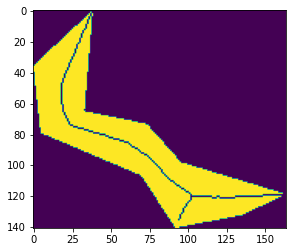

In [35]:
estim_skel = LengthEstimatorSkeleton(raster_arr, gt)
estim_skel.plot_skeleton()
print("longest path in graph = length of the polygon")

length_s = estim_skel.estimate()

print("length:", length_s)

Depending on the shape of the geometry, the two methods can yield fairly different results. As a generalisable approach, only the skeleton approach can be purposefully applied to real-world problems.

In [36]:
print("length with simple estimator:", length)
print("length with skeleton estimator:", length_s)

length with simple estimator: 21902.57317
length with skeleton estimator: 19587.61934
